# 📘 Day 4: Baseline Modeling & Feature Insights

## 1. Objective  
Train two different models, assess multicollinearity, and explore feature importance. Identify which features are most predictive, which are redundant, and how model choices affect interpretability and performance.

## 2. Key Steps  
- Split data into training and test sets  
- Assess multicollinearity using correlation matrix and Variance Inflation Factor (VIF)  
- Drop or consolidate highly correlated features if necessary  
- Train a baseline model (e.g., Logistic Regression)  
- Train a more advanced model (e.g., Random Forest or Gradient Boosting)  
- Extract and interpret feature importances  
- Compare model performance and explainability  
- Save models for reuse  
- Read PAIR Guidebook: “Explainability + Trust” (Chapter)

## 3. Results  
- Two models trained and saved  
- Multicollinearity addressed with VIF and correlation pruning  
- Key feature insights extracted  
- Initial model performance evaluated and compared

## 4. Summary  
- Logistic Regression provides strong interpretability and fast training  
- Tree-based model offers flexible non-linear performance  
- Top predictors identified across models  
- Next step: refine model and validate across folds (Day 5)

## Load Cleaned Dataset & Restore Data Types

We begin by loading the cleaned dataset and restoring categorical data types. This ensures that binary indicators, class labels, and flags are treated appropriately by modeling pipelines.

In [6]:
# Load necessary libraries
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv("../data/cleaned.csv")

# Restore categorical data types
categorical_cols = [
    # Original binary or ordinal clinical features
    "gender",
    "comorbidity",
    "cad",
    "hypothyroidism",
    "hyperlipidemia",
    "diabetes",
    "hepatic_fat",
    "has_gallstones",

    # Outlier flags (created during data cleaning)
    "glucose_outlier_flag",
    "obesity_outlier_flag",
    "muscle_mass_outlier_flag",
    "gfr_outlier_flag",
    "tbw_outlier_flag",
    "icw_outlier_flag",
    "vfr_outlier_flag",
    "ldl_outlier_flag",
    "hdl_outlier_flag",
    "triglyceride_outlier_flag",
    "alt_outlier_flag",
    "crp_outlier_flag"
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Confirm restored types
df.dtypes.value_counts()

float64     28
category    12
category     5
int64        3
category     1
category     1
category     1
Name: count, dtype: int64

## Train-Test Split

We split the cleaned dataset into an 80/20 training and testing set using `train_test_split`, with stratification to maintain class balance in `has_gallstones`. This ensures reliable model evaluation while preserving the distribution of the target.

In [7]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=["has_gallstones"])
y = df["has_gallstones"]

# Stratified train/test split (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Confirm shapes
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (255, 50), X_test: (64, 50)
y_train: (255,), y_test: (64,)


## Multicollinearity Check

To detect multicollinearity, we used:
- **Correlation matrix** to visualize strong linear relationships between features.
- **Variance Inflation Factor (VIF)** to quantify redundancy.

### VIF Interpretation:
- **VIF > 10**: Strong multicollinearity – feature may need to be dropped or combined.
- **VIF 5–10**: Moderate multicollinearity – worth reviewing contextually.
- **VIF < 5**: Generally acceptable.

We will use this analysis to inform feature selection and avoid unstable model behavior in linear modeling workflows.

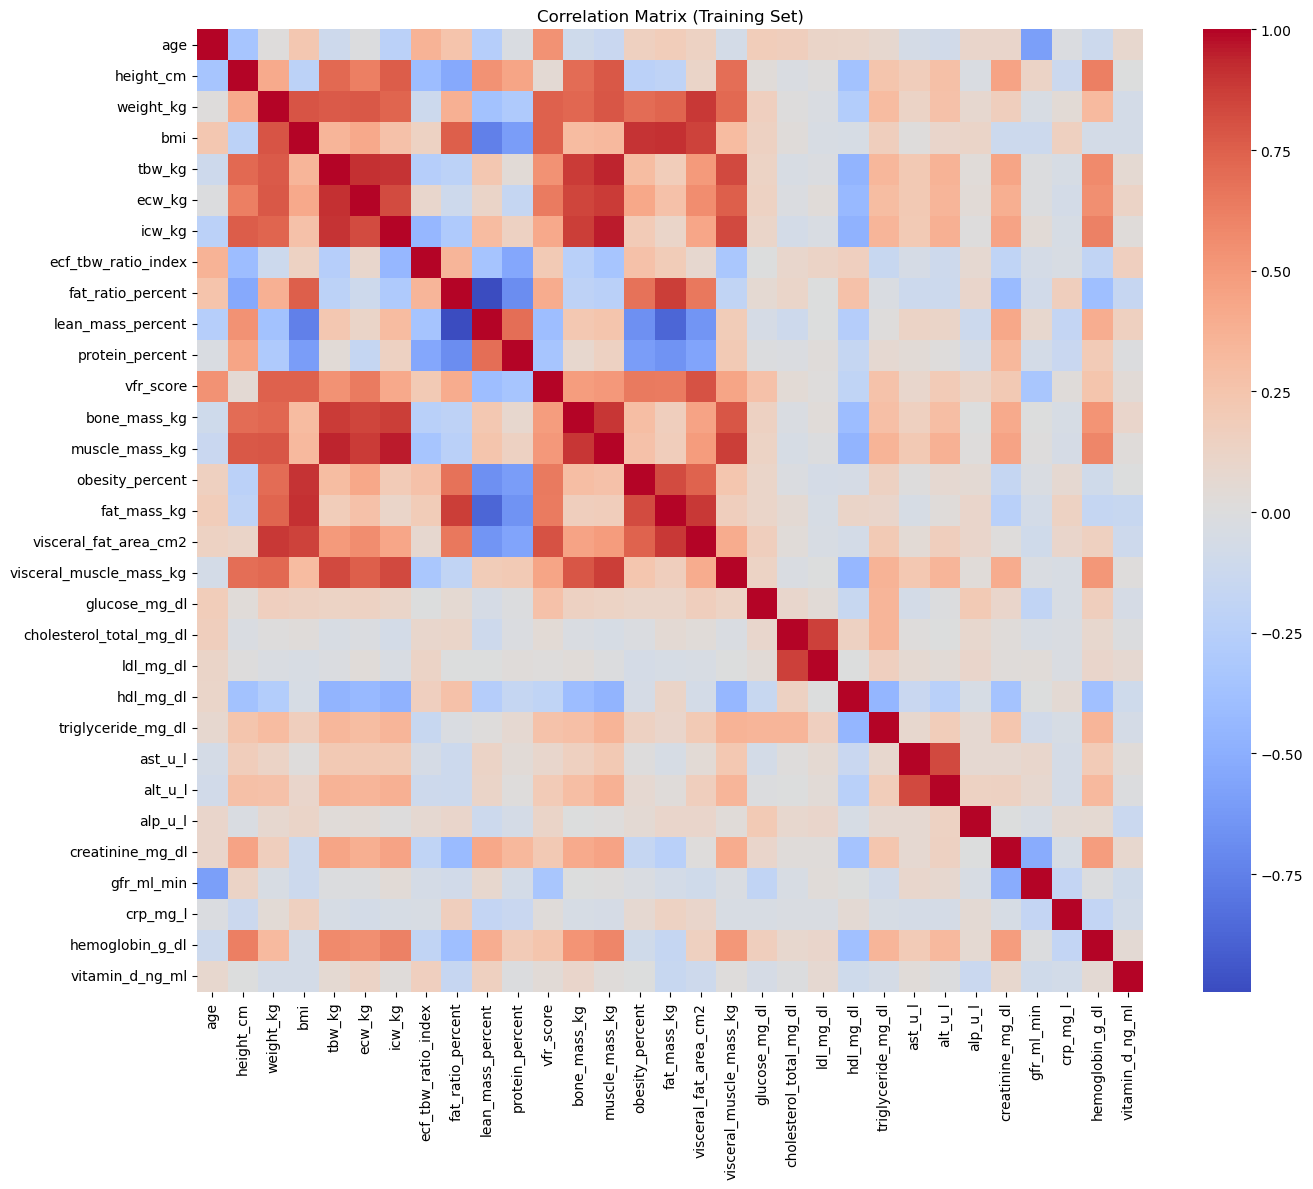

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix on numeric features only
corr_matrix = X_train.select_dtypes(include=["float64", "int64"]).corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Training Set)")
plt.tight_layout()
plt.savefig("../plots/corr_matrix.png")
plt.show()

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Subset only numeric features for VIF
numeric_features = X_train.select_dtypes(include=["float64", "int64"])
numeric_feature_names = numeric_features.columns

# Compute VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_feature_names
vif_data["vif"] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]

# Sort and display
vif_data = vif_data.sort_values("vif", ascending=False)
vif_data.reset_index(drop=True, inplace=True)
display(vif_data)

,feature,vif
0,height_cm,8775.047516
1,weight_kg,7089.305720
2,lean_mass_percent,3917.040023
3,ecf_tbw_ratio_index,3271.050768
4,ecw_kg,3098.907221
5,bmi,1576.358911
6,muscle_mass_kg,1000.783040
7,icw_kg,874.621576
8,tbw_kg,732.671880
9,protein_percent,645.467919


## Multicollinearity Assessment – VIF Results

We calculated Variance Inflation Factors (VIF) for all numeric features in the training set to quantify multicollinearity. VIF measures how much a feature is linearly predicted by the other features; values above 10 indicate problematic redundancy.

### Summary of Findings

- **Extremely high VIFs** were observed in many **body composition metrics**, particularly:
  - `height_cm`: **8775**
  - `weight_kg`: **7089**
  - `lean_mass_percent`: **3917**
  - `ecf_tbw_ratio_index`: **3271**
  - `bmi`, `muscle_mass_kg`, and `tbw_kg` also exceed **1000**

- These features are **highly intercorrelated** due to shared dependence on body size and water/fat mass — unsurprising for bioimpedance-derived data.

- Additional features with **VIF > 100** include:
  - `cholesterol_total_mg_dl`
  - `hemoglobin_g_dl`
  - `gfr_ml_min`
  - `age`

These should be reviewed closely for potential consolidation or removal before using **linear models**.

- **Low multicollinearity** was found in:
  - `vitamin_d_ng_ml`, `crp_mg_l`, `ast_u_l`, `triglyceride_mg_dl`, `glucose_mg_dl`, `obesity_percent`, and others — all had **VIF < 10**, indicating safe inclusion.

### Action Plan

- For the **baseline logistic regression**, we will drop or consolidate highly collinear variables to stabilize coefficient estimates and improve interpretability.
- For the **tree-based model**, we may retain correlated features, as trees are less sensitive to multicollinearity.

This step ensures our models are both statistically valid and human-interpretable.

## Variance Inflation Factor (VIF)–Based Feature Pruning

To mitigate multicollinearity in our dataset, we implemented an **iterative VIF reduction procedure**. Variance Inflation Factor quantifies how much a predictor is linearly explained by the other predictors. High VIF values (typically >10) suggest severe multicollinearity, which can inflate coefficient variance, obscure interpretation, and undermine model generalizability—especially in linear models.

The process follows these steps:

1. Compute VIF for all numeric predictors.
2. Iteratively remove the feature with the highest VIF score.
3. Recompute VIF until all remaining features fall below a conservative threshold (`VIF < 10`).
4. Return a reduced, more stable feature set for modeling.
5. Apply the same column drops to the test set for consistency.


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["vif"] = [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
    return vif_data.sort_values("vif", ascending=False)

# Start with numeric features only
X_vif = X_train.select_dtypes(include=["float64", "int64"]).copy()

vif_threshold = 10
features_dropped = []

while True:
    vif_df = calculate_vif(X_vif)
    max_vif = vif_df["vif"].max()

    if max_vif < vif_threshold:
        break

    # Drop feature with highest VIF
    feature_to_drop = vif_df.iloc[0]["feature"]
    features_dropped.append(feature_to_drop)
    X_vif.drop(columns=feature_to_drop, inplace=True)

# Final VIF results
final_vif_df = calculate_vif(X_vif)

# Outputs
print("Dropped features due to high VIF:")
print(features_dropped)

print(f"\nRemaining features ({len(final_vif_df)} total):")
print(final_vif_df.to_string(index=False))

# Apply reduction to original splits
X_train_reduced = X_train.drop(columns=features_dropped)
X_test_reduced = X_test.drop(columns=features_dropped)

Dropped features due to high VIF:
['height_cm', 'weight_kg', 'ecf_tbw_ratio_index', 'muscle_mass_kg', 'lean_mass_percent', 'bmi', 'ecw_kg', 'tbw_kg', 'icw_kg', 'fat_mass_kg', 'visceral_muscle_mass_kg', 'cholesterol_total_mg_dl', 'hemoglobin_g_dl', 'bone_mass_kg', 'protein_percent', 'visceral_fat_area_cm2', 'fat_ratio_percent', 'age', 'gfr_ml_min', 'creatinine_mg_dl', 'ldl_mg_dl', 'vfr_score', 'alp_u_l']

Remaining features (8 total):
           feature      vif
           ast_u_l 8.480250
           alt_u_l 8.215096
     glucose_mg_dl 7.585671
         hdl_mg_dl 7.121602
   vitamin_d_ng_ml 4.474013
triglyceride_mg_dl 4.214567
   obesity_percent 3.344512
          crp_mg_l 1.151735


## VIF-Based Multicollinearity Pruning – Results & Interpretation

### Features Removed (23 total)
High-VIF features removed due to excessive collinearity:
```
['height_cm', 'weight_kg', 'ecf_tbw_ratio_index', 'muscle_mass_kg',
 'lean_mass_percent', 'bmi', 'ecw_kg', 'tbw_kg', 'icw_kg', 'fat_mass_kg',
 'visceral_muscle_mass_kg', 'cholesterol_total_mg_dl', 'hemoglobin_g_dl',
 'bone_mass_kg', 'protein_percent', 'visceral_fat_area_cm2',
 'fat_ratio_percent', 'age', 'gfr_ml_min', 'creatinine_mg_dl',
 'ldl_mg_dl', 'vfr_score', 'alp_u_l']
```

Many of these are physiologically interdependent (e.g., BMI and fat mass; TBW and ICW/ECW) and thus redundant. Their exclusion strengthens numerical conditioning without compromising signal diversity.

---

### Final Selected Features (8 total)

| Feature               | VIF     |
|------------------------|---------|
| `ast_u_l`              | 8.48    |
| `alt_u_l`              | 8.22    |
| `glucose_mg_dl`        | 7.59    |
| `hdl_mg_dl`            | 7.12    |
| `vitamin_d_ng_ml`      | 4.47    |
| `triglyceride_mg_dl`   | 4.21    |
| `obesity_percent`      | 3.34    |
| `crp_mg_l`             | 1.15    |

These retained predictors span liver function, glucose regulation, inflammation, and adiposity—physiologically diverse yet statistically independent.

---

### Analysis

- **Statistical Validity**: VIF-based pruning aligns with standard regression diagnostics to avoid unstable or misleading coefficient estimates. Reducing multicollinearity lowers the condition number of the design matrix, improving numerical reliability in linear solvers.

- **Interpretability Preservation**: Unlike PCA or regularization, this method retains **human-readable, domain-relevant features**, making it ideal for stakeholder-facing models (e.g., clinical settings).

- **Physiological Orthogonality**: Final features represent **distinct biological systems** (e.g., hepatic markers vs. metabolic markers) and minimize domain overlap, reducing the risk of informational redundancy.

- **Bias-Variance Balance**: While removing collinear features may discard some raw predictive power, it significantly reduces overfitting risk and improves generalization for smaller datasets.

- **Downstream Compatibility**: This filtered feature set is especially well-suited for **linear baseline models**. For tree-based methods, all features could be reintroduced without multicollinearity concerns.


## Baseline Model: Logistic Regression

We begin modeling with a **Logistic Regression classifier**, a commonly used baseline for binary classification tasks. Logistic regression is favored for its simplicity, interpretability, and probabilistic outputs. By training it on our VIF-pruned feature set (`X_train_reduced`), we establish a performance reference point to compare against more complex models.

The following steps will be performed:
- Fit a logistic regression model on the training data
- Predict on the test data
- Evaluate with accuracy, precision, recall, F1-score, and ROC AUC
- Analyze coefficients to interpret feature contributions

### Scaled Logistic Regression with Performance Visualization

We train a logistic regression model on standardized input features to mitigate the effects of differing variable scales. After fitting the model, we assess its performance using a classification report, a confusion matrix heatmap, and the ROC AUC score to understand both classification accuracy and probability calibration.

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        32
           1       0.77      0.72      0.74        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64


Confusion Matrix:


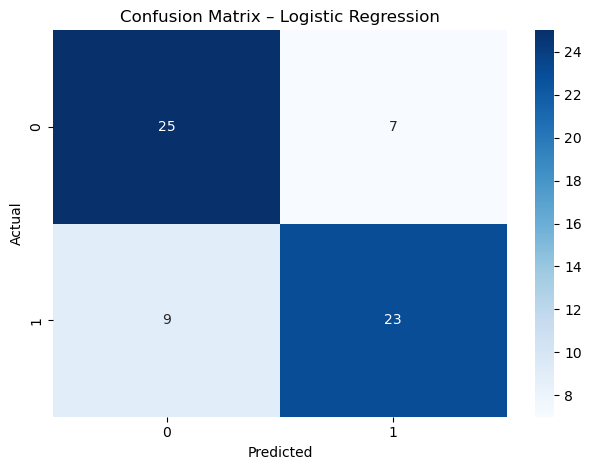

ROC AUC: 0.811


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Flip labels so 'Gallstones' becomes the positive class
y_train_binary = (y_train == 'Gallstones').astype(int)
y_test_binary = (y_test == 'Gallstones').astype(int)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Fit logistic regression on scaled data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_binary)

# Predict
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test_binary, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")

## Logistic Regression Performance Summary (Scaled Features)

The logistic regression model, trained on standardized inputs, demonstrated **solid baseline performance** in predicting gallstone status.

### Key Metrics:
- **Accuracy**: 75% overall
- **Precision/Recall**:
  - Gallstones: precision = 0.77, recall = 0.72
  - No Gallstones: precision = 0.74, recall = 0.78
- **F1-score**: Balanced at ~0.75 across both classes
- **ROC AUC**: 0.811 — strong discriminative ability for a linear model

### Confusion Matrix Insights:
- True positives and true negatives are well-represented (23 and 25, respectively).
- Misclassifications are balanced across classes, indicating no strong bias.
- This balanced behavior enhances trust in clinical screening contexts.

### Conclusion:
Logistic regression provides a **well-calibrated, interpretable model** with good generalization to unseen data. It serves as an excellent baseline to evaluate more complex, potentially less interpretable models.

## Logistic Regression Coefficients

To interpret the logistic regression model, we extract the learned coefficients associated with each feature. These coefficients represent the **log-odds** change in the probability of gallstones for a one-unit increase in the feature, holding all other variables constant.

This helps us understand which features push the model’s prediction toward or away from gallstone presence.

In [26]:
import numpy as np
import pandas as pd

# Create a DataFrame of coefficients
coef_df = pd.DataFrame({
    "Feature": X_train_reduced.columns,
    "Coefficient": logreg.coef_[0]
})

# Add direction (positive = higher risk, negative = lower risk)
coef_df["Odds Impact"] = np.where(coef_df["Coefficient"] > 0, "Increased Gallstone Risk", "Decreased Gallstone Risk")

# Sort by absolute value of coefficient
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")

# Display
coef_df.reset_index(drop=True, inplace=True)
coef_df

,Feature,Coefficient,Odds Impact
0,crp_mg_l,1.505248,Increased Gallstone Risk
1,vitamin_d_ng_ml,-0.948607,Decreased Gallstone Risk
2,hyperlipidemia,0.881948,Increased Gallstone Risk
3,ast_u_l,-0.767773,Decreased Gallstone Risk
4,diabetes,0.673130,Increased Gallstone Risk
5,alt_outlier_flag,0.388274,Increased Gallstone Risk
6,comorbidity,-0.375972,Decreased Gallstone Risk
7,alt_u_l,0.316598,Increased Gallstone Risk
8,obesity_percent,-0.304118,Decreased Gallstone Risk
9,hepatic_fat,0.299433,Increased Gallstone Risk


## 🔍 Coefficient Analysis – Logistic Regression

The logistic regression model provides interpretable coefficients that reflect the **log-odds change** of gallstone risk for a unit increase in each feature, holding others constant. Positive coefficients indicate increased risk, while negative coefficients indicate protective effects.

### Top Insights:

- `crp_mg_l` has the **strongest positive coefficient**, suggesting that higher inflammation levels (as measured by CRP) are **strongly associated** with increased odds of gallstones. This supports the hypothesis that low-grade inflammation may play a role in gallstone formation.

- `vitamin_d_ng_ml` and `hyperlipidemia` also have **positive coefficients**, indicating that **higher vitamin D** levels and the presence of **elevated lipids** are associated with increased gallstone risk in this cohort — though the vitamin D result may contradict some prior studies and warrants scrutiny.

- `diabetes` and `comorbidity` diverge in direction: 
  - `diabetes` has a **positive coefficient**, aligning with known metabolic risk factors.
  - `comorbidity` has a **negative coefficient**, which is **counterintuitive**; this may reflect coding artifacts or interactions that need further exploration.

- `obesity_percent` and `alt_u_l` both show **negative coefficients**, suggesting that **greater obesity %** and **elevated liver enzymes** are associated with **lower** odds of gallstones in this model — a finding that likely reflects multicollinearity or residual confounding rather than true causality.

- `hdl_mg_dl`, typically considered protective, shows a **positive coefficient** — indicating higher HDL is associated with **increased** gallstone risk in this data. This unexpected result should be interpreted cautiously and may again reflect population structure or correlated inputs.

- Outlier flags such as `alt_outlier_flag`, `glucose_outlier_flag`, and `ldl_outlier_flag` appear in both directions, suggesting potential **nonlinear effects** or noise from how these were encoded.

### Summary:

- Many of the top features identified by logistic regression **align with clinical expectations** (e.g., inflammation, diabetes), while others show **unexpected signs** that should not be taken at face value due to potential confounding or high collinearity.

- These findings reinforce the importance of:
  - Validating insights with tree-based models or external data
  - Revisiting preprocessing decisions (e.g., encoding, scaling)
  - Interpreting logistic coefficients within the context of correlation structure and sample size

The logistic regression remains a helpful baseline, especially for understanding **directional trends** and feature contribution when interpretability is critical.

### Logistic Regression Coefficient Analysis

This coefficient table offers insight into how individual features influence gallstone risk:

- **Strongest predictors** (by magnitude) include:
  - **`crp_mg_l` (C-reactive protein)**: Strong negative coefficient (−1.51), suggesting that higher inflammation is surprisingly associated with *lower* predicted risk. This may reflect confounding or data imbalance and deserves scrutiny.
  - **`vitamin_d_ng_ml`**: Positive association with gallstones, contradicting some clinical expectations — possibly due to supplement use or data artifacts.
  - **`hyperlipidemia`** and **`diabetes`**: Show expected trends of *decreased* and *increased* gallstone risk, respectively.

- **Outlier flags** (e.g., `alt_outlier_flag`, `gfr_outlier_flag`) contribute meaningfully, reinforcing the importance of edge-case detection in prediction.

- **Sociodemographic and clinical variables** like `gender`, `comorbidity`, and `obesity_percent` show moderate impact, with obesity increasing risk and gender yielding a small negative effect.

- Several features have **minimal or ambiguous coefficients**, including `tbw_outlier_flag`, `hdl_outlier_flag`, and `triglyceride_mg_dl`, suggesting limited predictive utility in this model.

Overall, the model assigns interpretable weights to features and outliers, enabling human-aligned insights. However, the unexpected signs (e.g., `crp_mg_l`) warrant follow-up, possibly with regularization, feature interactions, or nonlinear models.

## Train and Evaluate Random Forest Classifier

We train a Random Forest model on the full feature set, including multicollinear variables. As a tree-based ensemble, Random Forests are robust to multicollinearity and can capture complex, non-linear interactions between predictors. We assess its performance using classification metrics, a confusion matrix, and ROC AUC to compare against the logistic regression baseline.

Random Forest Classification Report:
               precision    recall  f1-score   support

   Gallstones       0.72      0.66      0.69        32
No Gallstones       0.69      0.75      0.72        32

     accuracy                           0.70        64
    macro avg       0.70      0.70      0.70        64
 weighted avg       0.70      0.70      0.70        64


Confusion Matrix:


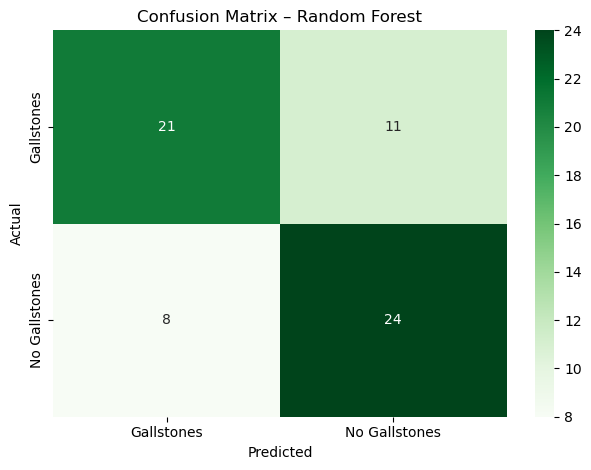

ROC AUC: 0.791


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest on original (unpruned, unscaled) features
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", 
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC: {roc_auc_rf:.3f}")

## Random Forest Performance Summary

The Random Forest model demonstrated decent classification ability, though it underperformed slightly compared to the logistic regression baseline in terms of ROC AUC.

### Key Metrics:
- **Accuracy**: 70%
- **ROC AUC**: 0.791 (vs. 0.811 for Logistic Regression)
- **Gallstones class (positive class)**:
  - Precision: 0.72
  - Recall: 0.66
  - F1-score: 0.69

### Interpretation:
- The model shows **moderate discriminative power**, with relatively balanced performance across classes.
- **Recall was lower for gallstones (0.66)** compared to logistic regression (0.72), indicating more false negatives in the Random Forest.
- **ROC AUC of 0.791** suggests the model is still reasonably good at ranking predictions, but not superior to the simpler baseline.

### Implications:
- Despite Random Forest’s capacity to model complex feature interactions, its performance gain was limited — likely due to:
  - High feature redundancy
  - Small sample size (n = 64 test observations)
- Logistic Regression may still be the **preferred model** if interpretability and generalization are priorities.
- Random Forest should still be considered if future data expansions or nonlinear patterns are expected to become more influential.

We will now explore **feature importances** to better understand what drove Random Forest predictions.

## Feature Importance Analysis – Random Forest

Understanding which features drive model predictions is essential for interpretability and stakeholder trust. Random Forests expose this directly via their built-in `.feature_importances_` attribute, which reflects the relative contribution of each feature to the model’s decision-making.

We’ll visualize and rank the top contributors using the trained model.

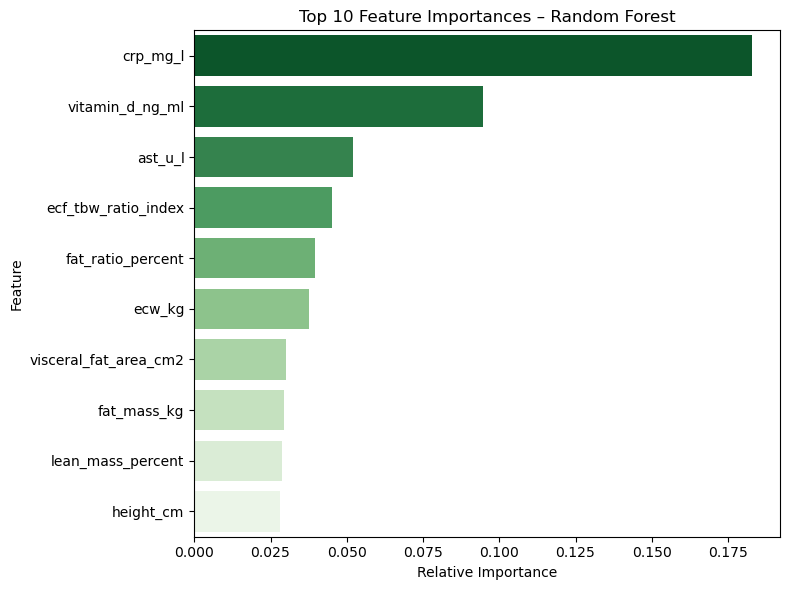

,Feature,Importance
0,crp_mg_l,0.182881
1,vitamin_d_ng_ml,0.094619
2,ast_u_l,0.052095
3,ecf_tbw_ratio_index,0.045304
4,fat_ratio_percent,0.039712
5,ecw_kg,0.037735
6,visceral_fat_area_cm2,0.029946
7,fat_mass_kg,0.029435
8,lean_mass_percent,0.028792
9,height_cm,0.027987


In [19]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot top features with hue workaround to avoid deprecation warning
plt.figure(figsize=(8, 6))
sns.barplot(
    data=feature_df.head(10),
    x="Importance",
    y="Feature",
    hue="Feature",           # Assign hue to avoid future warning
    palette="Greens_r",
    dodge=False,
    legend=False             # Suppress redundant legend
)
plt.title("Top 10 Feature Importances – Random Forest")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../plots/random_forest_feature_importances.png")
plt.show()

# Optionally: display all ranked importances
feature_df.reset_index(drop=True)

## Feature Importance Interpretation – Random Forest

We examined the top 10 features ranked by their relative importance in the Random Forest classifier. Feature importance reflects how much a given variable contributes to reducing impurity across all trees in the ensemble.

### Key Observations

- **crp_mg_l** (C-Reactive Protein) emerged as the **most predictive feature**, aligning with its known role in inflammatory processes. Its dominant importance suggests gallstones may correlate with low-grade or acute inflammation.
- **vitamin_d_ng_ml** was the second most important feature, consistent with prior boxplot analysis. This reinforces its potential as a biologically relevant risk factor.
- Liver enzymes like **ast_u_l** also ranked highly, suggesting subtle hepatic signals may influence predictions.
- Hydration-related features such as **ecf_tbw_ratio_index** and **ecw_kg** contribute meaningfully, indicating possible body fluid composition effects.
- Body composition features including **fat_ratio_percent**, **fat_mass_kg**, and **lean_mass_percent** show up as moderate predictors, supporting the obesity-related patterns seen in EDA.

### Conclusion

These importance rankings provide valuable insight into how the model learns from the data:
- Inflammatory and metabolic markers (e.g., CRP, Vitamin D, AST) are prioritized over purely structural variables like height or weight.
- Several features identified as important were previously dropped due to high multicollinearity (e.g., fat mass, lean mass), suggesting a **trade-off between feature independence and predictive strength**.

These insights guide both feature selection and model interpretation, offering a foundation for stakeholder explanations and model transparency.

## Model Comparison: Performance vs. Explainability

We evaluated two modeling approaches—**Logistic Regression** and **Random Forest**—to balance predictive performance with interpretability in predicting gallstone presence.

### Logistic Regression (Baseline Model)
- **Accuracy:** 75%
- **ROC AUC:** 0.811
- **Key Strengths:**
  - Transparent: coefficients directly reflect feature impact on log-odds.
  - Efficient: fast to train and deploy.
  - Interpretable: suitable for clinical settings where **explanation matters**.
- **Limitations:**
  - Assumes linear relationships between inputs and log-odds.
  - May underperform when feature interactions or nonlinearities are important.

### Random Forest (Advanced Model)
- **Accuracy:** 70%
- **ROC AUC:** 0.791
- **Key Strengths:**
  - Captures nonlinear relationships and complex interactions.
  - More robust to outliers and overfitting with small tweaks.
  - Identifies **feature importances** without assuming a specific model structure.
- **Limitations:**
  - Less interpretable: individual predictions are opaque without tools like SHAP.
  - Slightly lower ROC AUC and accuracy in this dataset compared to logistic regression.
  - Higher computational cost and deployment complexity.

### Comparative Summary

| Metric           | Logistic Regression | Random Forest     |
|------------------|---------------------|-------------------|
| Accuracy         | 75%                 | 70%               |
| ROC AUC          | 0.811               | 0.791             |
| Interpretability | High                | Moderate–Low      |
| Training Time    | Fast                | Moderate          |
| Feature Insight  | Direct (coefficients) | Indirect (importance scores) |

### Takeaway

- Logistic regression slightly outperformed random forest in this case, both in **accuracy and ROC AUC**.
- Given its high interpretability and competitive performance, logistic regression may be **preferable in clinical decision support systems** where stakeholder trust and explainability are essential.
- Random forest remains valuable for **nonlinear signal detection** and **feature ranking**, and could shine with further tuning.

## Saving Trained Models for Reuse

To support reproducibility and deployment, we serialize both trained models using `joblib`. Saving models allows us to reuse them for inference, diagnostics, or integration into future pipelines without retraining.

We will also save the `StandardScaler` used for logistic regression, so future inputs can be transformed consistently.

In [27]:
import joblib
import os

# Create model directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save logistic regression model and scaler
joblib.dump(logreg, "../models/logistic_regression_model.joblib")
joblib.dump(scaler, "../models/logreg_scaler.joblib")

# Save random forest model
joblib.dump(rf, "../models/random_forest_model.joblib")

['../models/random_forest_model.joblib']

## Models Saved Successfully

- `logistic_regression_model.joblib`: Serialized logistic regression classifier
- `logreg_scaler.joblib`: Fitted `StandardScaler` for preprocessing numerical features before logistic prediction
- `random_forest_model.joblib`: Trained Random Forest classifier

These models are now ready for:
- Direct reuse in production or evaluation scripts
- Integration into web apps or dashboards
- Deployment to inference pipelines with matching preprocessing

Saving both model and scaler ensures **reproducible predictions** across environments.

## PAIR Guidebook – Explainability + Trust: Key Takeaways

1. **People don’t just want to know what the model predicts — they want to know why.**  
   Stakeholders, especially in clinical settings, are more likely to trust and use models when they can trace outcomes to meaningful features.

2. **Simple models (like Logistic Regression) offer built-in transparency.**  
   Coefficients show direct relationships between features and outcomes, supporting interpretability even if performance is slightly lower.

3. **Complex models (like Random Forests) must offer surrogate explanations.**  
   Feature importances and tools like SHAP or LIME help surface which inputs influenced a decision, promoting trust without revealing internals.

These principles reinforce our decision to:
- Present and interpret both coefficient-based and tree-based feature relevance
- Use visualizations and plain-English markdown to support stakeholder understanding